In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def load_npy_image(file_path):
    """Load a .npy image file."""
    try:
        return np.load(file_path)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None  # Return None if loading fails

def resize_image(image, size=(224, 224)):
    """Resize an image to a given size."""
    resized_image = tf.image.resize(image, size)
    return resized_image.numpy()  # Convert to NumPy array after resizing

def normalize_image(image):
    """Normalize image values to range [0, 1]."""
    if image is not None:
        return image.astype(np.float32) / 255.0  # Normalize to [0, 1]
    return None

def load_and_preprocess_images(data_dir, num_samples=5):
    """Load and preprocess images for the inpainting task."""
    masked_files = sorted(
        [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith("masked_")]
    )
    
    images = []
    for i, file_path in enumerate(masked_files[:num_samples]):
        img = load_npy_image(file_path)
        print(img.shape)
        if img is not None:
            img = resize_image(img)
            img = normalize_image(img)
            images.append(img)
            # Check dimensions for compatibility
            check_image_dimensions(img)
        else:
            print(f"Skipping {file_path} due to loading error.")

    return images

def check_image_dimensions(image):
    """Check if the image has the correct dimensions."""
    if image.ndim != 3 or image.shape[-1] != 3:
        raise ValueError(f"Image dimensions are not compatible: {image.shape}. Expected shape: [height, width, 3]")

def display_images(images):
    """Display images in a grid."""
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


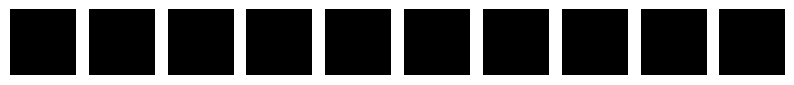

In [4]:
data_dir = r"F:\ssl_images\data\processed\coco\inpainting"  # Use raw string
images = load_and_preprocess_images(data_dir, 10)
display_images(images)


In [3]:
import tensorflow as tf
a = tf.io.read_file(r"F:\ssl_images\data\processed\coco\inpainting\masked_0.npy")


NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: F:\ssl_images\data\processed\coco\inpainting\masked_0.npy : The system cannot find the file specified.
; No such file or directory [Op:ReadFile]

In [1]:
!pip install scikit-image


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.8 MB 11.1 MB/s eta 0:00:02
   ---- ----------------------------------- 1.3/12.8 MB 14.1 MB/s eta 0:00:01
   ------- -------------------------------- 2.4/12.8 MB 17.0 MB/s eta 0:00:01
   ------------ --------------------------- 3.9/12.8 MB 20.6 MB/s eta 0:00:01
   ------------------ --------------------- 5.8/12.8 MB 24.9 MB/s eta 0:00:01
   -------------------------- ------------- 8.6/12.8 MB 30.5 MB/s eta 0:00:01
   ----------------------------------- ---- 11.5/12.8 MB 43.5 MB/s eta 0:00:01
   ---------------------------------------  12.8/12.8 MB 54.7 MB/s eta 0:00:01
   ---------------------------------------- 12.8/12.8 MB 46.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/315.4 kB ? eta -:--:--
   --------------------------------------- 315.4/315.4 kB 19.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/228.2 kB ? eta -:--:--
  

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import os
import tensorflow as tf
from tqdm import tqdm
import sys

#sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), "..")))
from src.models.resnet import ResNet50, ResNet18

from skimage.color import rgb2lab, lab2rgb  # Import for color space conversion

def load_and_preprocess_image(image_path):
    """Load and preprocess a single image for colorization."""
    # Load image
    img = np.load(image_path)
    
    # Convert to float and normalize
    img = tf.cast(img, tf.float32) #/ 255.0
    
    # Ensure grayscale input
    if len(img.shape) == 3 and img.shape[-1] == 3:
        img = tf.image.rgb_to_grayscale(img)
    
    # Add batch dimension
    img = tf.expand_dims(img, 0)
    
    return img

def visualize_colorization(model_path, image_path):
    """Load model, process image, and visualize results."""
    # Initialize model
    model = ResNet18((224, 224, 1))
    
    # Load trained weights
    model.load_weights(model_path)
    
    # Load and preprocess input image
    input_image = load_and_preprocess_image(image_path)
    
    # Get model prediction
    predicted_color = model.predict(input_image)
    L, a, b = tf.unstack(predicted_color, axis=-1)
    
    # Scale L channel to [0, 1]
    L = L * 100.0
    
    # Scale a and b channels to [0, 1]
    a = (a * 255.0) - 128.0  # Scale a from [-128, 127] to [0, 1]
    b = (b * 255.0) - 128.0  # Scale b from [-128, 127] to [0, 1]
    
    # Stack channels back together
    predicted_color = tf.stack([L, a, b], axis=-1)
    predicted_color = lab2rgb(predicted_color)
    
    # Remove batch dimension
    input_image = tf.squeeze(input_image)
    predicted_color = tf.squeeze(predicted_color) #* 255.0
    
    # Load original color image for comparison
    color_path = image_path.replace('gray', 'color')
    original_color = np.load(color_path)
    #original_color = lab2rgb(original_color)
    original_color = lab2rgb(original_color)
    original_color = original_color.astype(np.float32)
    
    # Create figure with three subplots
    plt.figure(figsize=(15, 5))
    
    # Plot grayscale input
    plt.subplot(1, 3, 1)
    plt.imshow(input_image, cmap='gray')
    plt.title('Grayscale Input')
    plt.axis('off')
    
    # Plot model prediction
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_color)
    plt.title('Model Colorization')
    plt.axis('off')
    
    # Plot original color image
    plt.subplot(1, 3, 3)
    plt.imshow(original_color)
    plt.title('Original Color')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    mae = tf.reduce_mean(tf.abs(original_color - predicted_color))
    mse = tf.reduce_mean(tf.square(original_color - predicted_color))
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Mean Absolute Error: {mse:.4f}")


F:\ssl_images\data\processed\coco\colorization\gray71.npy
Running colorization inference...
1/1 [==============================] - 1s 705ms/step


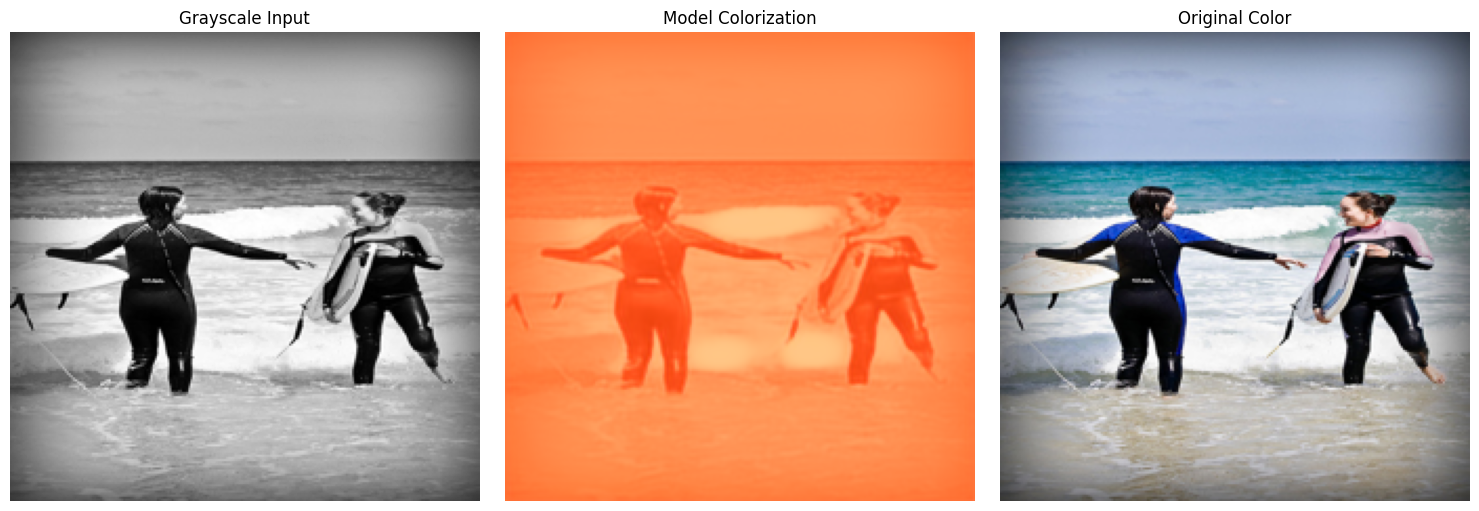

Mean Absolute Error: 0.3090
Mean Absolute Error: 0.1440
Visualization complete!


In [43]:
# Set up paths
model_path = os.path.join("models", "checkpoints", "model_epoch_003.h5")
data_dir = os.path.join("F:\\ssl_images\\data", "processed", "coco", 'colorization')

# Get a test image path (using the first grayscale image in the directory)
test_image = next(
    os.path.join(data_dir, f) 
    for f in os.listdir(data_dir) 
    if f.startswith("gray")
)
test_image = test_image.replace('0', '71')
print(test_image)

print("Running colorization inference...")
visualize_colorization(model_path, test_image)
print("Visualization complete!")

(224, 224)
0.4990952


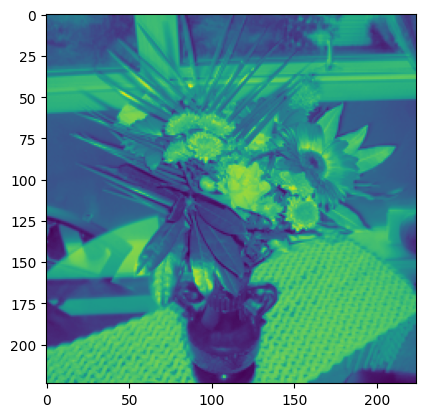

In [44]:
import os
def load_and_preprocess_image(image_path):
    """Load and preprocess a single image for colorization."""
    # Load image
    img = np.load(image_path)
    
    # Convert to float and normalize
    img = tf.cast(img, tf.float32) #/ 255.0

    
    # Add batch dimension
    img = tf.expand_dims(img, 0)
    
    return img

a = load_and_preprocess_image(os.path.join("F:\\ssl_images\\data", "processed", "coco", 'colorization', 'gray220.npy'))
a = tf.squeeze(a).numpy()
print(a.shape)
print(a.mean())
#print(lab2rgb(a).mean())
#plt.imshow(lab2rgb(a))
plt.imshow(a)

In [1]:
import tensorflow_io as tfio
import tensorflow as tf
class VGGPerceptualLoss(tf.keras.Model):
    def __init__(self, resize_inputs=True):
        super().__init__()
        # Load VGG19 pretrained on ImageNet
        vgg = tf.keras.applications.VGG19(include_top=False, weights="imagenet")
        vgg.trainable = False

        # We'll use these activation layers for perceptual loss
        output_layers = ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4"]

        outputs = [vgg.get_layer(name).output for name in output_layers]
        self.model = tf.keras.Model([vgg.input], outputs)
        self.resize_inputs = resize_inputs

    def call(self, inputs):
        # Preprocessing for VGG
        x = tf.keras.applications.vgg19.preprocess_input(inputs * 255.0)
        return self.model(x)


class ColorizationLoss(tf.keras.losses.Loss):
    def __init__(self, vgg_weight=1.0, l1_weight=1.0):
        super().__init__()
        self.vgg_model = VGGPerceptualLoss()
        self.mae = tf.keras.losses.MeanAbsoluteError()
        self.vgg_weight = vgg_weight
        self.l1_weight = l1_weight
    
    @staticmethod
    def inverse_scale_output(batch):
        # Ensure the batch has the expected shape
        if batch.shape[-1] != 3:
            raise ValueError(f"Expected batch to have 3 channels, got {batch.shape[-1]}")

        # Split the batch into L, a, and b channels
        L, a, b = tf.unstack(batch, 3, axis=-1)

        # Scale and shift channels using broadcasting
        L = L * 100.0
        a = (a * 255.0) - 128.0
        b = (b * 255.0) - 128.0

        # Combine channels using broadcasting
        return tf.stack([L, a, b], axis=-1)

    @staticmethod
    def lab_to_rgb(lab):
        """Convert LAB to RGB color space using TensorFlow operations."""
        # Efficient LAB to RGB conversion using TensorFlow's built-in functions
        lab = tf.image.convert_image_dtype(lab, dtype=tf.float32)
        rgb = tf.image.convert_image_dtype(tfio.experimental.color.lab_to_rgb(lab), dtype=tf.uint8)
        return tf.image.convert_image_dtype(rgb, dtype=tf.float32)
        
    def call(self, y_true, y_pred):
        # Ensure inputs have correct shape and data type
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        L, _, _ = tf.split(y_true, 3, axis=-1)
        y_pred = tf.concat([L, y_pred], axis=-1)

        # L1 loss in LAB space
        l1_loss = self.mae(y_true, y_pred)

        # Convert LAB to RGB for perceptual loss
        y_true_rgb = self.lab_to_rgb(self.inverse_scale_output(y_true))
        y_pred_rgb = self.lab_to_rgb(self.inverse_scale_output(y_pred))

        # VGG perceptual loss in RGB space
        vgg_true = self.vgg_model(y_true_rgb)
        vgg_pred = self.vgg_model(y_pred_rgb)

        perceptual_loss = 0.0
        for pt, pp in zip(vgg_true, vgg_pred):
            perceptual_loss += tf.reduce_mean(tf.square(pt - pp))

        # Combine losses
        total_loss = (self.l1_weight * l1_loss) + (self.vgg_weight * perceptual_loss)
        return total_loss
loss_fn = ColorizationLoss(0.5, 1.0)

In [2]:
def unscale(x):
    L, a, b = tf.unstack(x, axis=-1)

    # Scale L channel to [0, 1]
    L = L * 100.0

    # Scale a and b channels to [0, 1]
    a = (a * 255.0) - 128.0  # Scale a from [-128, 127] to [0, 1]
    b = (b * 255.0) - 128.0  # Scale b from [-128, 127] to [0, 1]

    # Stack channels back together
    return tf.stack([L, a, b], axis=-1)

def scale(x):
    L, a, b = tf.unstack(x, axis=-1)

    # Scale L channel to [0, 1]
    L = L / 100.0

    # Scale a and b channels to [0, 1]
    a = (a + 128.0) / 255.0  # Scale a from [-128, 127] to [0, 1]
    b = (b + 128.0) / 255.0  # Scale b from [-128, 127] to [0, 1]

    # Stack channels back together
    return tf.stack([L, a, b], axis=-1)

In [12]:
from time import sleep
#sleep(60*4)
#for i in range(1, 1000):
i = 89
image_path = os.path.join("F:\\ssl_images\\data", "processed", "coco", 'colorization', f'gray{i}.npy')
"""Load model, process image, and visualize results."""
# Initialize model
model = ResNet50((224, 224, 1))

# Load trained weights
model.load_weights(os.path.join("models", "checkpoints", "model_epoch_016.h5"))

# Load and preprocess input image
input_image = load_and_preprocess_image(image_path)

# Get model prediction
y_pred_raw = model.predict(input_image)
y_pred = tf.concat([input_image, y_pred_raw], axis=-1)

# Stack channels back together
predicted_color = unscale(y_pred)

def lab_to_rgb(lab):
    """Convert LAB to RGB color space using TensorFlow operations."""
    # Efficient LAB to RGB conversion using TensorFlow's built-in functions
    lab = tf.image.convert_image_dtype(lab, dtype=tf.float32)
    rgb = tf.image.convert_image_dtype(tfio.experimental.color.lab_to_rgb(lab), dtype=tf.uint8)
    return tf.image.convert_image_dtype(rgb, dtype=tf.float32)

predicted_color = lab_to_rgb(predicted_color)

# Remove batch dimension
input_image = tf.squeeze(input_image)
predicted_color = tf.squeeze(predicted_color)

# Load original color image for comparison
color_path = image_path.replace('gray', 'color')
y_true = np.load(color_path)
original_color = lab2rgb(y_true)
y_true = scale(y_true)
original_color = original_color.astype(np.float32)
print(loss_fn(tf.expand_dims(y_true, 0), y_pred_raw))


1/1 [==============================] - 1s 1s/step
tf.Tensor(50370.52, shape=(), dtype=float32)


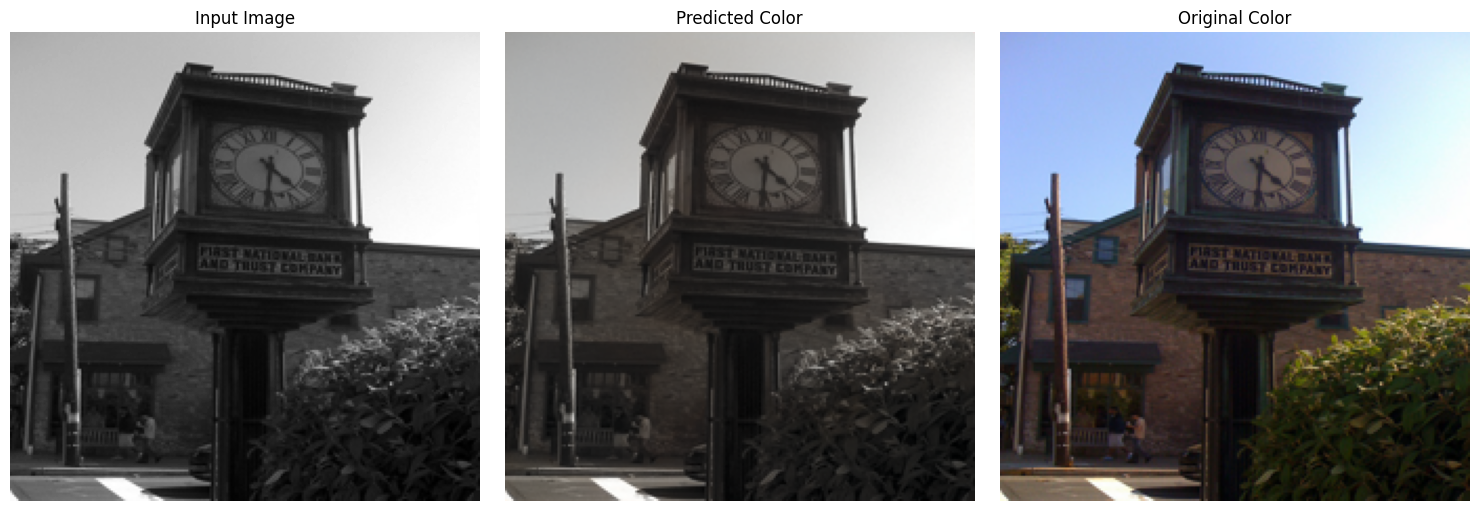

In [13]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Display the images
axs[0].imshow(input_image, cmap='gray')
axs[0].set_title('Input Image')
axs[0].axis('off')  # Hide axes

axs[1].imshow(predicted_color)
axs[1].set_title('Predicted Color')
axs[1].axis('off')  # Hide axes

axs[2].imshow(original_color)
axs[2].set_title('Original Color')
axs[2].axis('off')  # Hide axes

# Show the plot
plt.tight_layout()
plt.show()


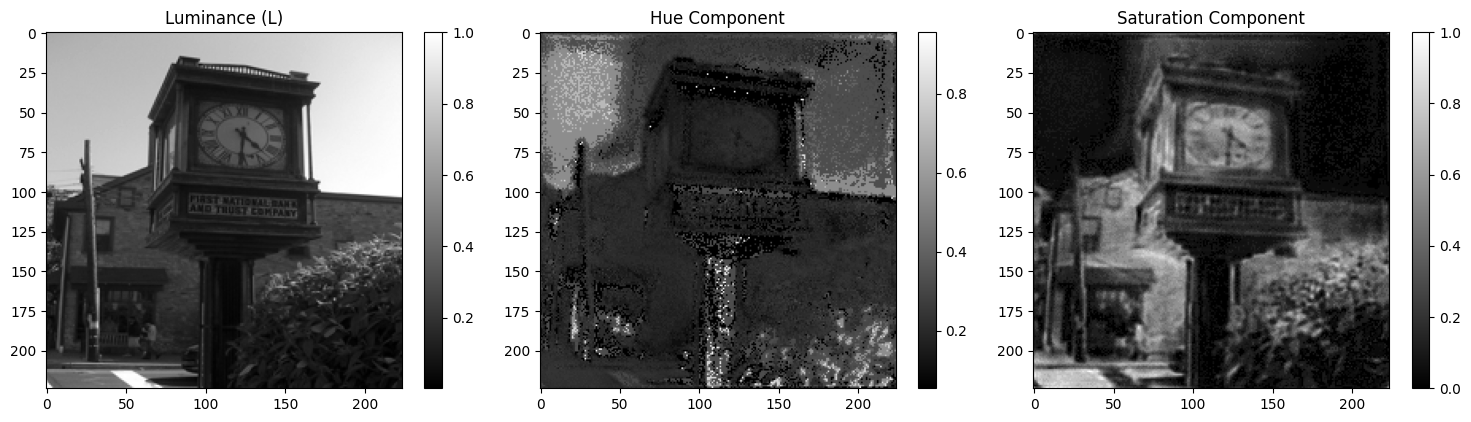

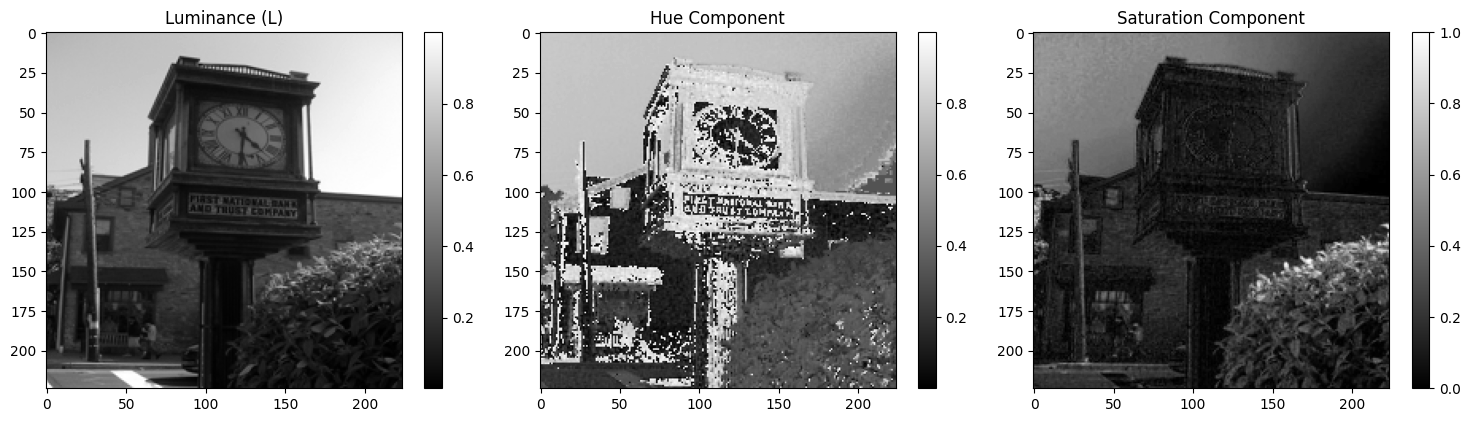

(array([[0.68913794, 0.69466054, 0.6993965 , ..., 0.9042321 , 0.9058384 ,
         0.9029818 ],
        [0.69531035, 0.69629496, 0.69230795, ..., 0.90840334, 0.9048873 ,
         0.9116259 ],
        [0.6982139 , 0.6996561 , 0.7015016 , ..., 0.9155064 , 0.9103922 ,
         0.91390413],
        ...,
        [0.9890306 , 0.96445173, 0.5737157 , ..., 0.07600168, 0.07315952,
         0.07254364],
        [0.9831346 , 0.99214417, 0.9646738 , ..., 0.08193449, 0.07982855,
         0.07315952],
        [0.9847418 , 0.9832567 , 0.99277216, ..., 0.08271214, 0.07744425,
         0.0748755 ]], dtype=float32),
 array([[0.7746124 , 0.77860445, 0.78071266, ..., 0.703785  , 0.7134864 ,
         0.7166222 ],
        [0.7799986 , 0.79012334, 0.78937346, ..., 0.7067419 , 0.7067724 ,
         0.7028071 ],
        [0.78569293, 0.7813212 , 0.7849203 , ..., 0.7018115 , 0.69120085,
         0.6911721 ],
        ...,
        [0.30424923, 0.32320413, 0.34718615, ..., 0.32406655, 0.31819847,
         0.31623828

In [14]:
import numpy as np
from matplotlib import pyplot as plt
from skimage import color

def visualize_color_components(rgb_image):
    """
    Convert RGB image to LAB colorspace and display luminance, hue and saturation components
    using skimage.color.
    
    Parameters:
    rgb_image: numpy.ndarray
        Input RGB image with values in range [0, 1] or [0, 255]
    
    Returns:
    tuple: (luminance_image, hue_image, saturation_image) as numpy arrays
    """
    # Ensure input is float in range [0, 1]
    if rgb_image.max() > 1.0:
        rgb_image = rgb_image / 255.0
        
    # Convert RGB to LAB
    lab = color.rgb2lab(rgb_image)
    
    # Extract L, a and b components
    luminance = lab[..., 0]  # L component is already in [0, 100] range
    a = lab[..., 1]
    b = lab[..., 2]
    
    # Calculate hue (in degrees)
    hue = np.rad2deg(np.arctan2(b, a)) % 360
    
    # Calculate saturation (chroma in LAB space)
    saturation = np.sqrt(np.square(a) + np.square(b))
    
    # Normalize components for display
    luminance_normalized = luminance / 100.0  # L is in range [0, 100]
    hue_normalized = hue / 360.0
    saturation_normalized = (saturation - saturation.min()) / (saturation.max() - saturation.min())
    
    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
    
    # Display luminance component
    lum_img = ax1.imshow(luminance_normalized, cmap='gray')
    ax1.set_title('Luminance (L)')
    plt.colorbar(lum_img, ax=ax1)
    
    # Display hue component
    hue_img = ax2.imshow(hue_normalized, cmap='gray')
    ax2.set_title('Hue Component')
    plt.colorbar(hue_img, ax=ax2)
    
    # Display saturation component
    sat_img = ax3.imshow(saturation_normalized, cmap='gray')
    ax3.set_title('Saturation Component')
    plt.colorbar(sat_img, ax=ax3)
    
    plt.tight_layout()
    plt.show()
    
    return luminance_normalized, hue_normalized, saturation_normalized

visualize_color_components(predicted_color.numpy())
visualize_color_components(original_color)

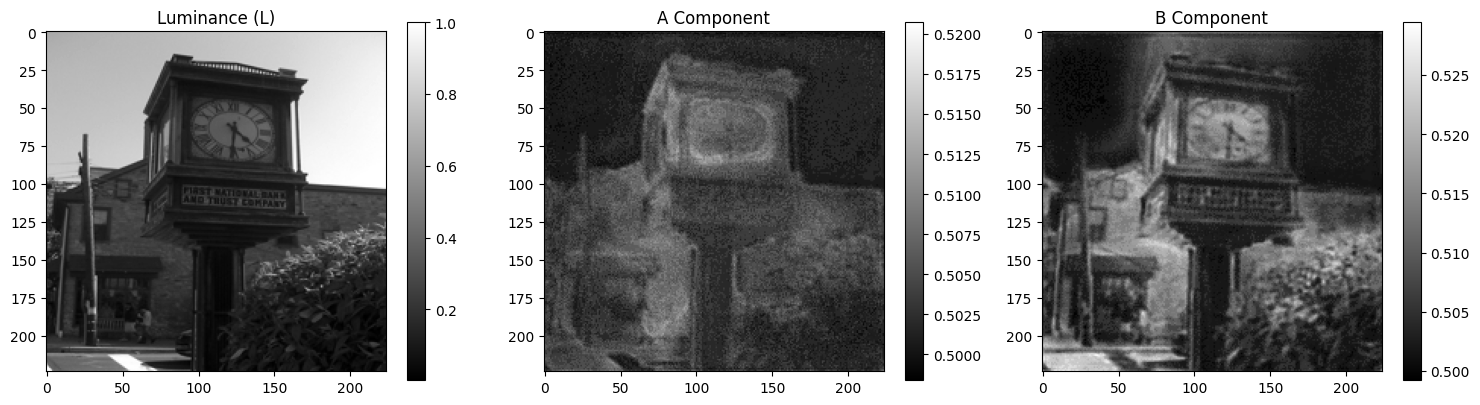

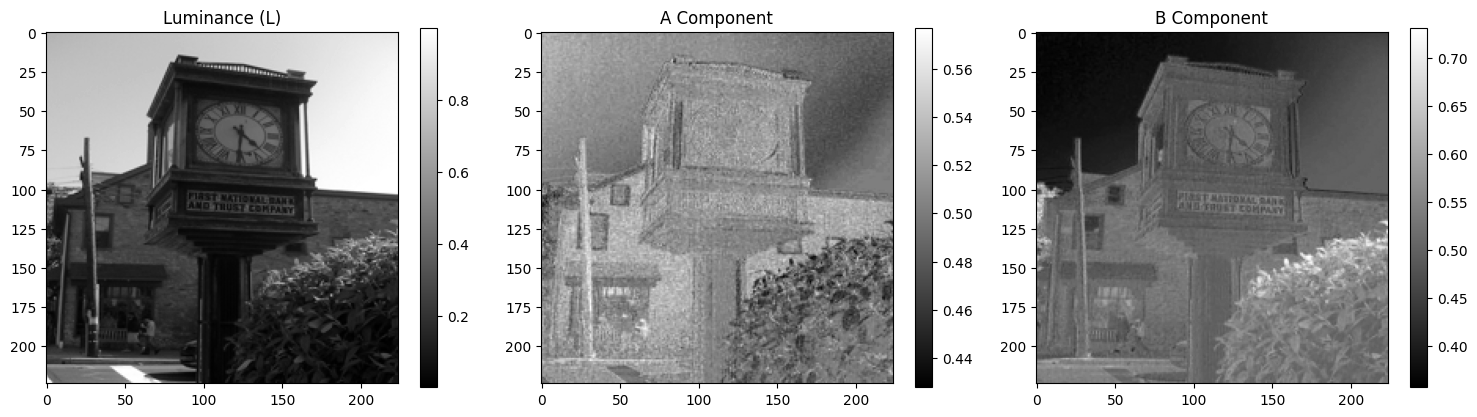

In [15]:
import numpy as np
from matplotlib import pyplot as plt
from skimage import color

def visualize_color_components_lab(rgb_image):
    """
    Convert RGB image to LAB colorspace and display luminance, hue and saturation components
    using skimage.color.
    
    Parameters:
    rgb_image: numpy.ndarray
        Input RGB image with values in range [0, 1] or [0, 255]
    
    Returns:
    tuple: (luminance_image, hue_image, saturation_image) as numpy arrays
    """
    # Ensure input is float in range [0, 1]
    if rgb_image.max() > 1.0:
        rgb_image = rgb_image / 255.0
        
    # Convert RGB to LAB
    lab = color.rgb2lab(rgb_image)
    
    # Extract L, a and b components
    luminance = lab[..., 0]  # L component is already in [0, 100] range
    a = lab[..., 1]
    b = lab[..., 2]

    a_normalized = (a+128.)/255.
    b_normalized = (b+128.)/255.
    # Normalize components for display
    luminance_normalized = luminance / 100.0  # L is in range [0, 100]
    
    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
    
    # Display luminance component
    lum_img = ax1.imshow(luminance_normalized, cmap='gray')
    ax1.set_title('Luminance (L)')
    plt.colorbar(lum_img, ax=ax1)
    
    # Display hue component
    a_img = ax2.imshow(a_normalized, cmap='gray')
    ax2.set_title('A Component')
    plt.colorbar(a_img, ax=ax2)
    
    # Display saturation component
    b_img = ax3.imshow(b_normalized, cmap='gray')
    ax3.set_title('B Component')
    plt.colorbar(b_img, ax=ax3)
    
    plt.tight_layout()
    plt.show()

visualize_color_components_lab(predicted_color.numpy())
visualize_color_components_lab(original_color)

In [16]:
import numpy as np
from skimage import color

def compute_lab_metrics(y_true, y_pred):
    """
    Convert RGB images to LAB color space and compute MAE and MSE for A and B components.
    
    Parameters:
    y_true: numpy.ndarray
        Ground truth RGB image with values in range [0, 1] or [0, 255]
    y_pred: numpy.ndarray
        Predicted RGB image with values in range [0, 1] or [0, 255]
        
    Returns:
    dict: Dictionary containing MAE and MSE for A and B components
    """
    # Ensure inputs are float in range [0, 1]
    if y_true.max() > 1.0:
        y_true = y_true / 255.0
    if y_pred.max() > 1.0:
        y_pred = y_pred / 255.0
    
    # Convert RGB to LAB
    lab_true = color.rgb2lab(y_true)
    lab_pred = color.rgb2lab(y_pred)
    
    # Extract A and B components
    a_true = (lab_true[..., 1] + 128.)/255.  # A component
    b_true = (lab_true[..., 2] + 128.)/255.  # B component
    a_pred = (lab_pred[..., 1] + 128.)/255.  # A component
    b_pred = (lab_pred[..., 2] + 128.)/255.  # B component
    
    # Compute metrics for A component
    mae_a = np.mean(np.abs(a_true - a_pred))
    mse_a = np.mean(np.square(a_true - a_pred))
    
    # Compute metrics for B component
    mae_b = np.mean(np.abs(b_true - b_pred))
    mse_b = np.mean(np.square(b_true - b_pred))
    
    metrics = {
        'mae_a': mae_a,
        'mse_a': mse_a,
        'mae_b': mae_b,
        'mse_b': mse_b,
        'mean_mae': (mae_a + mae_b) / 2,
        'mean_mse': (mse_a + mse_b) / 2,
        'rmse_a': np.sqrt(mse_a),
        'rmse_b': np.sqrt(mse_b)
    }
    
    return metrics

def print_metrics(metrics):
    """
    Helper function to print metrics in a formatted way.
    
    Parameters:
    metrics: dict
        Dictionary containing the computed metrics
    """
    print("A Component Metrics:")
    print(f"  MAE: {metrics['mae_a']:.4f}")
    print(f"  MSE: {metrics['mse_a']:.4f}")
    print(f"  RMSE: {metrics['rmse_a']:.4f}")
    print("\nB Component Metrics:")
    print(f"  MAE: {metrics['mae_b']:.4f}")
    print(f"  MSE: {metrics['mse_b']:.4f}")
    print(f"  RMSE: {metrics['rmse_b']:.4f}")
    print("\nMean Metrics:")
    print(f"  Mean MAE: {metrics['mean_mae']:.4f}")
    print(f"  Mean MSE: {metrics['mean_mse']:.4f}")

print_metrics(compute_lab_metrics(original_color, predicted_color.numpy()))

A Component Metrics:
  MAE: 0.0143
  MSE: 0.0003
  RMSE: 0.0177

B Component Metrics:
  MAE: 0.0406
  MSE: 0.0034
  RMSE: 0.0580

Mean Metrics:
  Mean MAE: 0.0274
  Mean MSE: 0.0018


In [17]:
from src.models.experimental_resnet import ResNet18, ResNet50  # Import your ResNet implementation

model = ResNet18((224, 224, 3))
model.summary()

Model: "ResNet18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 64)         9472      ['input_5[0][0]']             
                                                                                                  
 bn1 (BatchNormalization)    (None, 112, 112, 64)         256       ['conv1[0][0]']               
                                                                                                  
 leaky_re_lu_84 (LeakyReLU)  (None, 112, 112, 64)         0         ['bn1[0][0]']                 
                                                                                           

C:\Users\gabri\AppData\Local\Temp\ipykernel_17504\2998451165.py:47: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1850 negative Z values that have been clipped to zero
  rgb_from_lab = color.lab2rgb(lab_pred)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


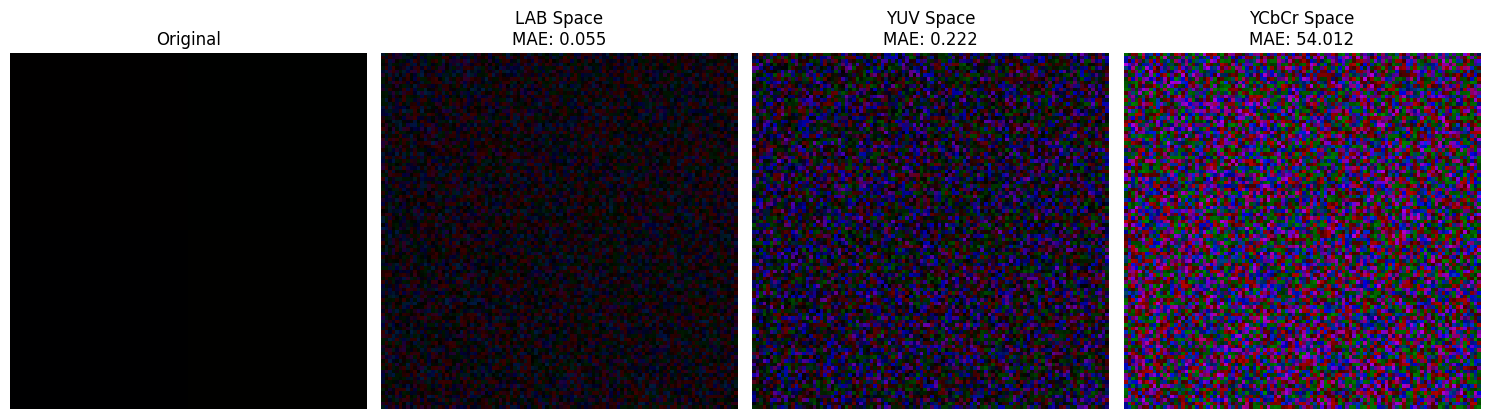


Color Preservation Analysis:

LAB Space:
Hue Difference: 0.3326
Saturation Difference: 0.0000

YUV Space:
Hue Difference: 0.3426
Saturation Difference: 1.5050

YCBCR Space:
Hue Difference: 0.3392
Saturation Difference: 0.0000


In [89]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
import cv2

class ColorSpaceComparison:
    def __init__(self, target_mae=0.1):
        """
        Initialize comparison with target MAE to demonstrate in each color space
        """
        self.target_mae = target_mae
        
    def generate_synthetic_prediction_error(self, original_values, target_mae):
        """
        Generate synthetic prediction errors that result in specified MAE
        """
        # Create noise that will result in our target MAE
        noise_scale = target_mae * np.sqrt(12)  # For uniform distribution
        noise = np.random.uniform(-noise_scale, noise_scale, original_values.shape)
        return np.clip(original_values + noise, -1, 1)

    def compare_spaces(self, image_rgb):
        """
        Compare how similar MAE values look in different color spaces
        """
        # Normalize input image
        image_rgb = image_rgb.astype(np.float32) / 255.0
        
        results = {}
        
        # LAB Space
        lab = color.rgb2lab(image_rgb)
        lab_norm = lab.copy()
        lab_norm[..., 0] = lab_norm[..., 0] / 100  # L channel
        lab_norm[..., 1:] = lab_norm[..., 1:] / 127  # a,b channels
        
        # Add controlled noise to a,b channels
        lab_pred = lab_norm.copy()
        lab_pred[..., 1:] = self.generate_synthetic_prediction_error(
            lab_norm[..., 1:], self.target_mae
        )
        
        # Convert back to RGB
        lab_pred[..., 0] = lab_pred[..., 0] * 100
        lab_pred[..., 1:] = lab_pred[..., 1:] * 127
        rgb_from_lab = color.lab2rgb(lab_pred)
        
        # YUV Space
        yuv = tf.image.rgb_to_yuv(image_rgb).numpy()
        
        # Add controlled noise to UV channels
        yuv_pred = yuv.copy()
        yuv_pred[..., 1:] = self.generate_synthetic_prediction_error(
            yuv[..., 1:], self.target_mae
        )
        
        # Convert back to RGB
        rgb_from_yuv = tf.image.yuv_to_rgb(yuv_pred).numpy()
        
        # YCbCr Space
        ycbcr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2YCrCb)
        ycbcr_norm = ycbcr.astype(np.float32) / 255.0
        
        # Add controlled noise to CbCr channels
        ycbcr_pred = ycbcr_norm.copy()
        ycbcr_pred[..., 1:] = self.generate_synthetic_prediction_error(
            ycbcr_norm[..., 1:], self.target_mae
        )
        
        # Convert back to RGB
        ycbcr_pred = (ycbcr_pred * 255.0).astype(np.uint8)
        rgb_from_ycbcr = cv2.cvtColor(ycbcr_pred, cv2.COLOR_YCrCb2RGB)
        
        # Calculate actual MAEs
        mae_lab = np.mean(np.abs(image_rgb - rgb_from_lab))
        mae_yuv = np.mean(np.abs(image_rgb - rgb_from_yuv))
        mae_ycbcr = np.mean(np.abs(image_rgb - rgb_from_ycbcr))
        
        return {
            'original': image_rgb,
            'lab': rgb_from_lab,
            'yuv': rgb_from_yuv,
            'ycbcr': rgb_from_ycbcr,
            'mae_values': {
                'lab': mae_lab,
                'yuv': mae_yuv,
                'ycbcr': mae_ycbcr
            }
        }

def visualize_comparison(results):
    """
    Create a visualization of the results
    """
    plt.figure(figsize=(15, 8))
    
    # Original
    plt.subplot(141)
    plt.imshow(results['original'])
    plt.title('Original')
    plt.axis('off')
    
    # LAB
    plt.subplot(142)
    plt.imshow(results['lab'])
    plt.title(f"LAB Space\nMAE: {results['mae_values']['lab']:.3f}")
    plt.axis('off')
    
    # YUV
    plt.subplot(143)
    plt.imshow(results['yuv'])
    plt.title(f"YUV Space\nMAE: {results['mae_values']['yuv']:.3f}")
    plt.axis('off')
    
    # YCbCr
    plt.subplot(144)
    plt.imshow(results['ycbcr'])
    plt.title(f"YCbCr Space\nMAE: {results['mae_values']['ycbcr']:.3f}")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage with synthetic color patches
def generate_test_image():
    """
    Generate a test image with various colors to highlight differences
    """
    size = 100
    image = np.zeros((size, size, 3))
    
    # Create color patches
    image[:size//2, :size//2] = [1.0, 0.0, 0.0]  # Red
    image[:size//2, size//2:] = [0.0, 1.0, 0.0]  # Green
    image[size//2:, :size//2] = [0.0, 0.0, 1.0]  # Blue
    image[size//2:, size//2:] = [1.0, 1.0, 0.0]  # Yellow
    
    return image

# Run comparison
test_image = generate_test_image()
comparator = ColorSpaceComparison(target_mae=0.1)
results = comparator.compare_spaces(test_image)
visualize_comparison(results)

# Now let's analyze color preservation properties
def analyze_color_preservation(results):
    """
    Analyze how well each color space preserves important color properties
    """
    spaces = ['lab', 'yuv', 'ycbcr']
    metrics = {}
    
    for space in spaces:
        result_img = results[space]
        
        # Calculate hue preservation
        original_hsv = color.rgb2hsv(results['original'])
        result_hsv = color.rgb2hsv(result_img)
        hue_diff = np.mean(np.abs(original_hsv[..., 0] - result_hsv[..., 0]))
        
        # Calculate saturation preservation
        sat_diff = np.mean(np.abs(original_hsv[..., 1] - result_hsv[..., 1]))
        
        metrics[space] = {
            'hue_difference': hue_diff,
            'saturation_difference': sat_diff
        }
    
    return metrics

preservation_metrics = analyze_color_preservation(results)
print("\nColor Preservation Analysis:")
for space, metrics in preservation_metrics.items():
    print(f"\n{space.upper()} Space:")
    print(f"Hue Difference: {metrics['hue_difference']:.4f}")
    print(f"Saturation Difference: {metrics['saturation_difference']:.4f}")

In [6]:
import os
import sys
import tensorflow as tf
import tensorflow.keras.backend as K

# Add the project root directory to the Python path
from src.models.resnet import ResNet18, load_encoder_weights

# Instantiate both models
colorization_model = ResNet18(input_shape=(224, 224, 1), mode='colorization')
segmentation_model = ResNet18(input_shape=(224, 224, 1), mode='segmentation')

pretrained_model = os.path.join("models", "checkpoints_resnet18_vgg", "best_model.h5")
#print(model.summary())

if pretrained_model:
    print("Loading model weights...")
    load_encoder_weights(colorization_model, pretrained_model)
    load_encoder_weights(segmentation_model, pretrained_model)

# Get encoder layers (up to the ResNet blocks)
colorization_layers = {layer.name: layer for layer in colorization_model.layers}# if "block" in layer.name}
segmentation_layers = {layer.name: layer for layer in segmentation_model.layers}# if "block" in layer.name}

# Compare weights
shared_weights = True
for name in colorization_layers:
    if name in segmentation_layers:
        colorization_weights = colorization_layers[name].get_weights()
        segmentation_weights = segmentation_layers[name].get_weights()
        if not all((w1 == w2).all() for w1, w2 in zip(colorization_weights, segmentation_weights)):
            print(f"Mismatch found in layer: {name}")
            shared_weights = False

if shared_weights:
    print("The encoders of both models share the same weights.")
else:
    print("The encoders of both models do not share the same weights.")


Loading model weights...
The encoders of both models share the same weights.


In [10]:
for name in colorization_layers:
    if name not in segmentation_layers:
        print('not in seg', name)

print(50*'-')
for name in segmentation_layers:
    if name not in colorization_layers:
        print('not in color', name)

not in seg input_9
not in seg leaky_re_lu_160
not in seg decoder_0_upsample
not in seg decoder_0_concat
not in seg decoder_0_conv1
not in seg decoder_0_bn1
not in seg leaky_re_lu_169
not in seg decoder_0_conv2
not in seg decoder_0_bn2
not in seg leaky_re_lu_170
not in seg decoder_1_upsample
not in seg decoder_1_concat
not in seg decoder_1_conv1
not in seg decoder_1_bn1
not in seg leaky_re_lu_171
not in seg decoder_1_conv2
not in seg decoder_1_bn2
not in seg leaky_re_lu_172
not in seg decoder_2_upsample
not in seg decoder_2_concat
not in seg decoder_2_conv1
not in seg decoder_2_bn1
not in seg leaky_re_lu_173
not in seg decoder_2_conv2
not in seg decoder_2_bn2
not in seg leaky_re_lu_174
not in seg decoder_3_upsample
not in seg decoder_3_concat
not in seg decoder_3_conv1
not in seg decoder_3_bn1
not in seg leaky_re_lu_175
not in seg decoder_3_conv2
not in seg decoder_3_bn2
not in seg leaky_re_lu_176
not in seg decoder_4_upsample
not in seg decoder_4_conv1
not in seg decoder_4_bn1
not in s

In [8]:
segmentation_layers

{'input_10': <keras.src.engine.input_layer.InputLayer at 0x25366899450>,
 'conv1': <keras.src.layers.convolutional.conv2d.Conv2D at 0x253668dad50>,
 'bn1': <keras.src.layers.normalization.batch_normalization.BatchNormalization at 0x25300be9250>,
 'leaky_re_lu_180': <keras.src.layers.activation.leaky_relu.LeakyReLU at 0x25300c11310>,
 'block_0_0': <src.models.resnet.ResNetBlock at 0x25364209890>,
 'block_0_1': <src.models.resnet.ResNetBlock at 0x253010336d0>,
 'block_1_0': <src.models.resnet.ResNetBlock at 0x2530103e2d0>,
 'block_1_1': <src.models.resnet.ResNetBlock at 0x25301031f90>,
 'block_2_0': <src.models.resnet.ResNetBlock at 0x2530109b610>,
 'block_2_1': <src.models.resnet.ResNetBlock at 0x25301101150>,
 'block_3_0': <src.models.resnet.ResNetBlock at 0x253010f67d0>,
 'block_3_1': <src.models.resnet.ResNetBlock at 0x253011532d0>,
 'decoder_seg_0_upsample': <keras.src.layers.reshaping.up_sampling2d.UpSampling2D at 0x253011a9a10>,
 'decoder_seg_0_concat': <keras.src.layers.merging.c

In [11]:
colorization_model.summary()

Model: "ResNet18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 64)         3200      ['input_9[0][0]']             
                                                                                                  
 bn1 (BatchNormalization)    (None, 112, 112, 64)         256       ['conv1[0][0]']               
                                                                                                  
 leaky_re_lu_160 (LeakyReLU  (None, 112, 112, 64)         0         ['bn1[0][0]']                 
 )                                                                                         